In [1]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, DMatrix
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from conditionalconformal import CondConf
import random


In [2]:
def add_average(train_df):
    # Create a copy of train_df
    train_df = train_df.copy()

    # Create a new column with initial value of 0
    train_df['mean_bid'] = 0
    
    # Calculate the average BidAmount for each Bidder and update the mean_bid column
    for bidder in train_df['Bidder'].unique():
        mean_bid = train_df.loc[train_df['Bidder'] == bidder, 'BidAmount'].mean()
        train_df.loc[train_df['Bidder'] == bidder, 'mean_bid'] = mean_bid

    return train_df


In [3]:

def add_0(train_df, new_df):
    # Create a copy of new_df
    new_df = new_df.copy()

    # Add a 'mean_bid' column to new_df with initial value of 0
    new_df['mean_bid'] = 0

    # Get the unique set of bidders from train_df
    bidders_set = set(train_df['Bidder'])

    # Iterate over each Bidder in new_df
    for bidder in new_df['Bidder']:
        bidder_rows = new_df[new_df['Bidder'] == bidder]
        if bidder not in bidders_set:
            new_df.loc[new_df['Bidder'] == bidder, 'mean_bid'] = 0
        else:
            mean_bid_value = train_df.loc[train_df['Bidder'] == bidder, 'mean_bid'].iloc[0]
            new_df.loc[new_df['Bidder'] == bidder, 'mean_bid'] = mean_bid_value

    return new_df



In [7]:
def trunctime(Table, time):
    
    condition = Table['BidTime'] <= time

    return Table[condition]


In [11]:
# Read the CSV file
Table_palm7 = pd.read_csv("/Users/jialehan/Desktop/Auction Dataset/eBay/Palm+7-day+149auctions+Curve+Clustering.csv")

# Filter the DataFrame
Table = Table_palm7[(Table_palm7['Seller'] == "syschannel") | (Table_palm7['Seller'] == "michael-33") | (Table_palm7['Seller'] == "saveking")]

# Initializes a Boolean sequence of False values for each row
false = pd.Series([False] * len(Table), index=Table.index)

# Loop through unique Auction.ID and Bidder
for j in Table['Auction ID'].unique():
    for i in Table[Table['Auction ID'] == j]['Bidder'].unique():
        max_bid = Table[(Table['Auction ID'] == j) & (Table['Bidder'] == i)]['BidAmount'].max()
        false |= ((Table['Auction ID'] == j) & (Table['Bidder'] == i) & (Table['BidAmount'] == max_bid))

# Create a new filtered DataFrame
Table_new = Table[false]
#Table_new

In [12]:
Table_new = add_average(Table_new)
trunctime(Table_new, 6.5)

,Auction ID,BidAmount,BidTime,Bidder,Bidder Rating,Closing Price,Opening Bid,Seller,Seller Rating,# Bids,End Date,mean_bid
0,2920504693,0.01,0.485127,nfl4life05,12,238.02,0.01,syschannel,1180.0,25,4/5/2003,0.0100
1,2920504693,45.01,0.577998,hnaja,7,238.02,0.01,syschannel,1180.0,25,4/5/2003,45.0100
6,2920504693,50.00,0.642870,chucky44441978,2,238.02,0.01,syschannel,1180.0,25,4/5/2003,50.0000
7,2920504693,48.00,0.975394,cesandjoel,69,238.02,0.01,syschannel,1180.0,25,4/5/2003,48.0000
8,2920504693,100.00,1.623264,notoriousrob,2,238.02,0.01,syschannel,1180.0,25,4/5/2003,100.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3025486868,101.00,1.717118,bonnieellarae,28,230.50,1.00,michael-33,72.0,28,5/25/2003,111.2000
3125,3025486868,125.00,2.146412,gryder2310-half,52,230.50,1.00,michael-33,72.0,28,5/25/2003,153.7500
3127,3025486868,132.75,2.747685,star-skipper,20,230.50,1.00,michael-33,72.0,28,5/25/2003,151.9375
3134,3025486868,180.00,5.647789,bubbayesch,7,230.50,1.00,michael-33,72.0,28,5/25/2003,180.0000


In [13]:


# Get unique Auction.ID for each Seller
Seller_syschannel = Table_new[Table_new['Seller'] == "syschannel"]['Auction ID'].unique()
Seller_michael = Table_new[Table_new['Seller'] == "michael-33"]['Auction ID'].unique()
Seller_saveking = Table_new[Table_new['Seller'] == "saveking"]['Auction ID'].unique()

# Create a list of DataFrames
Table_his_syschannel = []
Table_new_syschannel = []
for i in Seller_syschannel:
    Table_his_syschannel.append(Table_new[Table_new['Auction ID'] != i])
    Table_new_syschannel.append(Table_new[Table_new['Auction ID'] == i])
    
Table_his_michael = []
Table_new_michael = []
for i in Seller_michael:
    Table_his_michael.append(Table_new[Table_new['Auction ID'] != i])
    Table_new_michael.append(Table_new[Table_new['Auction ID'] == i])

Table_his_saveking = []
Table_new_saveking = []
for i in Seller_saveking:
    Table_his_saveking.append(Table_new[Table_new['Auction ID'] != i])
    Table_new_saveking.append(Table_new[Table_new['Auction ID'] == i])




In [14]:


def find_remaining_numbers(original_numbers, selected_numbers):
    remaining_numbers = [num for num in original_numbers if num not in selected_numbers]
    return remaining_numbers


def split(Table):
    Table = Table.reset_index(drop=True)
    train_df = pd.DataFrame(columns=Table.columns)
    cali_df = pd.DataFrame(columns=Table.columns)
    N = len(Table)
    half_N = int(N/2)
    selected_numbers = random.sample(list(range(1, N + 1)), half_N)
    train_N = sorted(selected_numbers)
    cali_N = find_remaining_numbers(list(range(1, N + 1)),train_N)
    cali_N = [x - 1 for x in cali_N ]
    train_N = [x - 1 for x in train_N]
    train_df = Table.loc[train_N]
    cali_df = Table.loc[cali_N]

    return train_df, cali_df


In [15]:
def phi_fn(feature):
    scalar_values = np.array(feature[:,3])

    # Initialize the indicator matrix
    matrix = np.zeros((len(scalar_values), 3))
    value_z = np.array(["syschannel","michael-33","saveking"])

    # Fill in the indicator matrix
    for i, value in enumerate(scalar_values):
        for j in range(0,3):
            if  value == value_z[j]:
                matrix[i, j] = 1

    return matrix

preprocessor = ColumnTransformer(
    transformers=[
        ('num', PolynomialFeatures(degree=2), ['x1', 'x2', 'x3']),  # 包含x3
        ('cat', OneHotEncoder(), ['z'])
    ])


In [16]:
def delete_none(train_df, new_df):

    unique_bidders = train_df['Bidder'].unique()
    
    new = new_df[new_df['Bidder'].isin(unique_bidders)]

    return new

In [17]:
import random


def change_N(Table_old,Table_new,trunc_time=6.5,time=100):
    IR = []
    prop = []
    differ = []
    Pay = []
    new_data_2nd = []
    welfare = []
    random_selections = [random.randint(0, len(Table_old)-1) for _ in range(time)]
    for i in random_selections:
        df_his = Table_old[i]
        #df_his = df_his.sample(n=N)
        df_his = trunctime(df_his, trunc_time)
        D_train = split(df_his)[0]#always 0
        D_cali = split(df_his)[1]#always 1
        Condition_data = delete_none(Table_old[i], Table_new[i])
        Condition_data  = trunctime(Condition_data, trunc_time)
        D_train = pd.DataFrame({'x1': D_train['BidTime'],'x2': D_train['mean_bid'], 'x3': D_train['Bidder Rating'], 'y': D_train['BidAmount'], 'z': D_train['Seller']})
        D_cali = pd.DataFrame({'x1': D_cali['BidTime'],'x2': D_cali['mean_bid'], 'x3': D_cali['Bidder Rating'], 'y': D_cali['BidAmount'], 'z': D_cali['Seller']})
        X = D_train[['x1', 'x2', 'x3', 'z']]
        y = D_train['y']
        model = make_pipeline(preprocessor, LinearRegression())
        model.fit(X, y)
        D_new = pd.DataFrame({'x1': Condition_data['BidTime'], 'x2': Condition_data['mean_bid'],'x3': Condition_data['Bidder Rating'],'y': Condition_data['BidAmount'], 'z': Condition_data['Seller']})
        X_new = D_new[['x1', 'x2', 'x3','z']]
        y_new = D_new['y']
        new_data = pd.DataFrame({'x1': D_new['x1'],'x2': D_new['x2'], 'x3': D_new['x3'],'z': D_new['z'], 'y': D_new['y']})
        y_new_predict = model.predict(X_new)
        score_fn = lambda feature,  y : abs(y - model.predict(pd.DataFrame({'x1': feature[:,0],'x2': feature[:,1],'x3': feature[:,2], 'z': feature[:,3]})))
        condCovProgram = CondConf(score_fn, phi_fn, {})
        condCovProgram.setup_problem(D_cali[['x1', 'x2', 'x3', 'z']].to_numpy(),D_cali['y'].to_numpy())
        alpha = 0.1
        Xtest = np.array([new_data[['x1', 'x2', 'x3', 'z']].to_numpy()[0,:]])
        d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
        hat_t_L = y_new_predict - d 
        hat_t_U = y_new_predict + d 
        IR.append(np.mean((hat_t_L <= new_data['y']) & (new_data['y'] <= hat_t_U)))
    
        reserve_price = hat_t_L
        virtual_value = new_data['y'] * (new_data['y'] > reserve_price)

        # Find the index(es) of the maximum virtual value
        max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]

        winner = None
        if len(max_virtual_value_indexes) > 1:
        # Check the reserve price for the max virtual value indexes
            max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

            if len(max_reserve_price_indexes) > 1:
            # If multiple maximums, choose one at random
                winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
            else:
            # If only one maximum
                winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
        else:
        # If only one maximum virtual value
            winner = max_virtual_value_indexes[0]

        sorted_virtual_value = np.sort(virtual_value)[::-1]


        sorted_virtual_value_2 = sorted_virtual_value[1] if len(sorted_virtual_value) >= 2 else 0

        payment = max(0, sorted_virtual_value_2, reserve_price[winner],Condition_data['Opening Bid'].iloc[0])
        max_welfare = np.max(new_data['y'])
        welfare.append(max_welfare)
        Pay.append(payment)
        prop.append(payment/max_welfare)

        new_data_2 = np.sort(new_data['y'])[::-1][1] if len(np.sort(new_data['y'])[::-1]) >= 2 else Condition_data['Opening Bid'].iloc[0]
        new_data_2nd.append(new_data_2)
        differ.append(payment - new_data_2)

    return np.mean(new_data_2nd), np.mean(Pay), np.mean(welfare), differ, IR, np.mean(prop)
    

In [21]:
random.seed(1)
num_runs = 100
payments, sb_values, max_welfares, Differ_, IR_coverage, Prop = [], [], [], [], [], []
for _ in range(num_runs):
    new_data_2nd_, Pay_, welfare_, differ_, IR_, prop_ = change_N(Table_his_syschannel, Table_new_syschannel, 6.5,50)
    sb_values.append(new_data_2nd_)
    payments.append(Pay_)
    max_welfares.append(welfare_)
    IR_coverage.append(np.mean(IR_))
    Prop.append(prop_)
    Differ_.append(np.mean(differ_))

In [22]:
payments_s, sb_values_s, max_welfares_s, Differ__s, IR_coverage_s, Prop_s = payments, sb_values, max_welfares, Differ_, IR_coverage, Prop


In [363]:
random.seed(1)
num_runs = 100
payments, sb_values, max_welfares, Differ_, IR_coverage, Prop = [], [], [], [], [], []
for _ in range(num_runs):
    new_data_2nd_, Pay_, welfare_, differ_, IR_, prop_ = change_N(Table_his_michael, Table_new_michael, 6.5,50)
    sb_values.append(new_data_2nd_)
    payments.append(Pay_)
    max_welfares.append(welfare_)
    IR_coverage.append(np.mean(IR_))
    Prop.append(prop_)
    Differ_.append(np.mean(differ_))




In [23]:
payments_m, sb_values_m, max_welfares_m, Differ__m, IR_coverage_m, Prop_m = payments, sb_values, max_welfares, Differ_, IR_coverage, Prop



In [373]:
random.seed(2)
num_runs = 100
payments, sb_values, max_welfares, Differ_, IR_coverage, Prop = [], [], [], [], [], []
for _ in range(num_runs):
    new_data_2nd_, Pay_, welfare_, differ_, IR_, prop_ = change_N(Table_his_saveking, Table_new_saveking, 6.5,50)
    sb_values.append(new_data_2nd_)
    payments.append(Pay_)
    max_welfares.append(welfare_)
    IR_coverage.append(np.mean(IR_))
    Prop.append(prop_)
    Differ_.append(np.mean(differ_))



In [25]:
payments_sa, sb_values_sa, max_welfares_sa, Differ__sa, IR_coverage_sa, Prop_sa = payments, sb_values, max_welfares, Differ_, IR_coverage, Prop


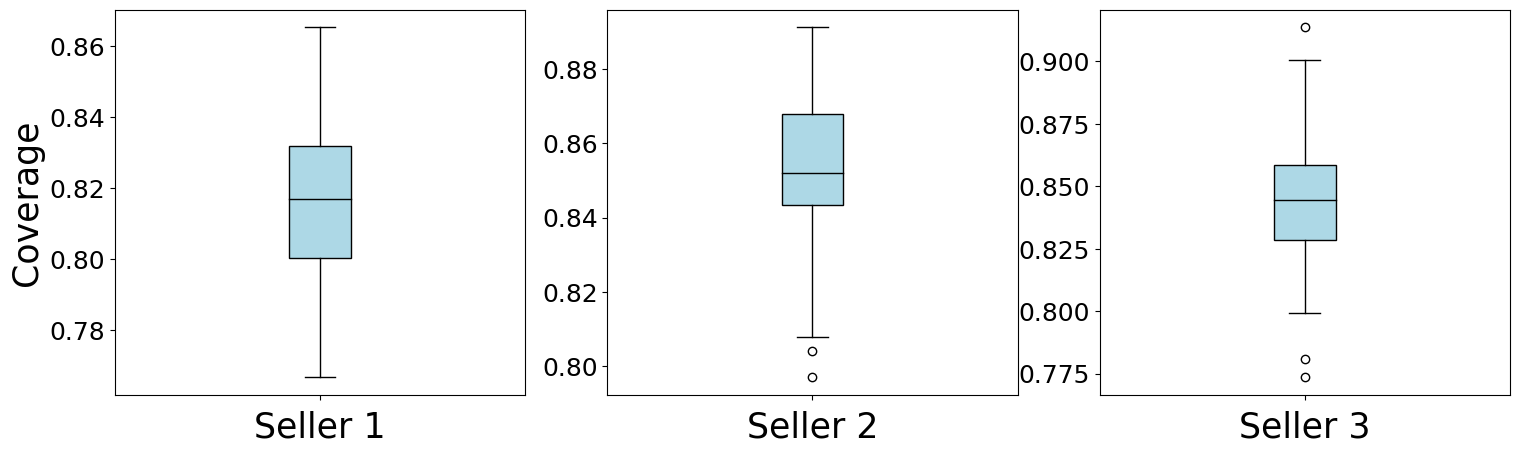

In [388]:
# Create a subplot with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 5)) # Adjust figsize as needed

# Customize the first subplot
axs[0].boxplot(IR_coverage_s, patch_artist=True, boxprops=dict(facecolor='lightblue'),
               medianprops=dict(color="black"))
axs[0].set_xlabel('Seller 1', fontsize=25)
axs[0].set_ylabel('Coverage', fontsize=25)
axs[0].tick_params(axis='y', labelsize=18)
axs[0].set_xticklabels([''])


# Draw a boxplot for IR_coverage_m on the second subplot
axs[1].boxplot(IR_coverage_m, patch_artist=True, boxprops=dict(facecolor='lightblue'),
               medianprops=dict(color="black"))
axs[1].set_xlabel('Seller 2', fontsize=25)
axs[1].tick_params(axis='y', labelsize=18)
axs[1].set_xticklabels([''])

# Draw a boxplot for IR_coverage_sa on the third subplot
axs[2].boxplot(IR_coverage_sa, patch_artist=True, boxprops=dict(facecolor='lightblue'),
               medianprops=dict(color="black"))
axs[2].set_xlabel('Seller 3', fontsize=25)
axs[2].tick_params(axis='y', labelsize=18)
axs[2].set_xticklabels([''])

# Show the entire plot
plt.show()




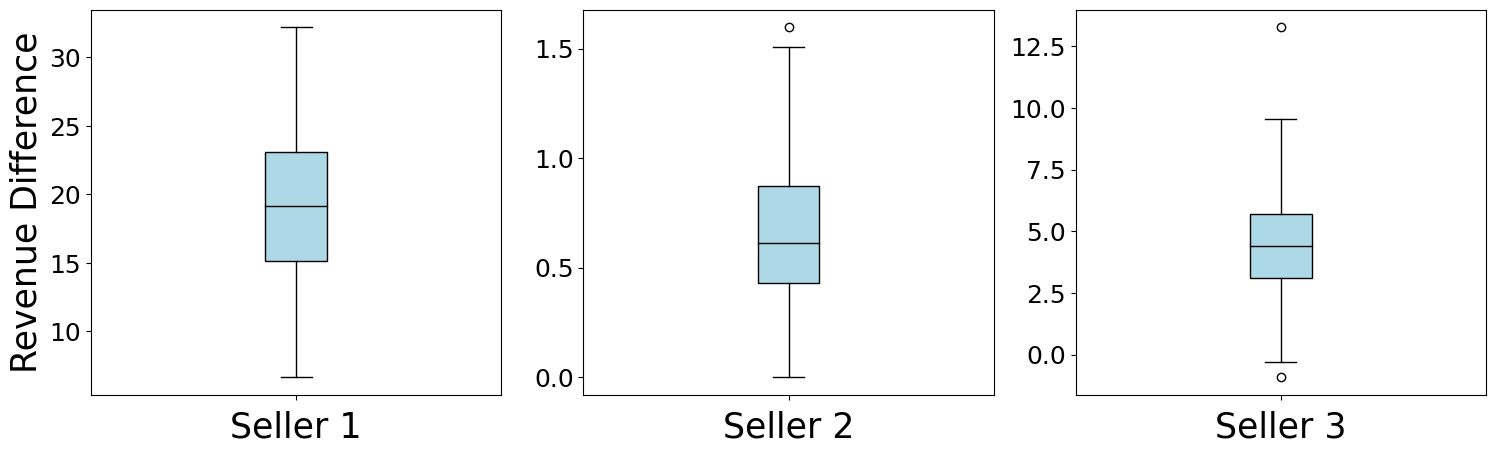

In [385]:
# Create a subplot with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 5)) # Adjust figsize as needed

# Customize the first subplot
axs[0].boxplot(Differ__s, patch_artist=True, boxprops=dict(facecolor='lightblue'),
               medianprops=dict(color="black"))
axs[0].set_xlabel('Seller 1', fontsize=25)
axs[0].set_ylabel('Revenue Difference', fontsize=25)
axs[0].tick_params(axis='y', labelsize=18)
axs[0].set_xticklabels([''])

# Draw a boxplot for Differ__m on the second subplot
axs[1].boxplot(Differ__m, patch_artist=True, boxprops=dict(facecolor='lightblue'),
               medianprops=dict(color="black"))
axs[1].set_xlabel('Seller 2', fontsize=25)
axs[1].tick_params(axis='y', labelsize=18)
axs[1].set_xticklabels([''])


# Draw a boxplot for Differ__sa on the third subplot
axs[2].boxplot(Differ__sa, patch_artist=True, boxprops=dict(facecolor='lightblue'),
               medianprops=dict(color="black"))
axs[2].set_xlabel('Seller 3', fontsize=25)
axs[2].tick_params(axis='y', labelsize=18)
axs[2].set_xticklabels([''])


# Show the entire plot
plt.show()


In [280]:
def change_N_N(Table_old,Table_new,trunc_time=6.5,N=800,time=100):
    IR = []
    prop = []
    differ = []
    Pay = []
    new_data_2nd = []
    welfare = []
    random_selections = [random.randint(0, len(Table_old)-1) for _ in range(time)]
    for i in random_selections:
        df_his = Table_old[i]
        df_his = df_his.sample(n=N)
        df_his = trunctime(df_his, trunc_time)
        D_train = split(df_his)[0]#always 0
        D_cali = split(df_his)[1]#always 1
        Condition_data = delete_none(Table_old[i], Table_new[i])
        Condition_data  = trunctime(Condition_data, trunc_time)
        D_train = pd.DataFrame({'x1': D_train['BidTime'],'x2': D_train['mean_bid'], 'x3': D_train['Bidder Rating'], 'y': D_train['BidAmount'], 'z': D_train['Seller']})
        D_cali = pd.DataFrame({'x1': D_cali['BidTime'],'x2': D_cali['mean_bid'], 'x3': D_cali['Bidder Rating'], 'y': D_cali['BidAmount'], 'z': D_cali['Seller']})
        X = D_train[['x1', 'x2', 'x3', 'z']]
        y = D_train['y']
        model = make_pipeline(preprocessor, LinearRegression())
        model.fit(X, y)
        D_new = pd.DataFrame({'x1': Condition_data['BidTime'], 'x2': Condition_data['mean_bid'],'x3': Condition_data['Bidder Rating'],'y': Condition_data['BidAmount'], 'z': Condition_data['Seller']})
        X_new = D_new[['x1', 'x2', 'x3','z']]
        y_new = D_new['y']
        new_data = pd.DataFrame({'x1': D_new['x1'],'x2': D_new['x2'], 'x3': D_new['x3'],'z': D_new['z'], 'y': D_new['y']})
        y_new_predict = model.predict(X_new)
        score_fn = lambda feature,  y : abs(y - model.predict(pd.DataFrame({'x1': feature[:,0],'x2': feature[:,1],'x3': feature[:,2], 'z': feature[:,3]})))
        condCovProgram = CondConf(score_fn, phi_fn, {})
        condCovProgram.setup_problem(D_cali[['x1', 'x2', 'x3', 'z']].to_numpy(),D_cali['y'].to_numpy())
        alpha = 0.1
        Xtest = np.array([new_data[['x1', 'x2', 'x3', 'z']].to_numpy()[0,:]])
        d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
        hat_t_L = y_new_predict - d 
        hat_t_U = y_new_predict + d 
        IR.append(np.mean((hat_t_L <= new_data['y']) & (new_data['y'] <= hat_t_U)))
    
        reserve_price = hat_t_L
        virtual_value = new_data['y'] * (new_data['y'] > reserve_price)

        # Find the index(es) of the maximum virtual value
        max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]

        winner = None
        if len(max_virtual_value_indexes) > 1:
        # Check the reserve price for the max virtual value indexes
            max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

            if len(max_reserve_price_indexes) > 1:
            # If multiple maximums, choose one at random
                winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
            else:
            # If only one maximum
                winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
        else:
        # If only one maximum virtual value
            winner = max_virtual_value_indexes[0]

        sorted_virtual_value = np.sort(virtual_value)[::-1]


        sorted_virtual_value_2 = sorted_virtual_value[1] if len(sorted_virtual_value) >= 2 else 0

        payment = max(0, sorted_virtual_value_2, reserve_price[winner],Condition_data['Opening Bid'].iloc[0])
        max_welfare = np.max(new_data['y'])
        welfare.append(max_welfare)
        Pay.append(payment)
        prop.append(payment/max_welfare)

        new_data_2 = np.sort(new_data['y'])[::-1][1] if len(np.sort(new_data['y'])[::-1]) >= 2 else Condition_data['Opening Bid'].iloc[0]
        new_data_2nd.append(new_data_2)
        differ.append(payment - new_data_2)

    return np.mean(new_data_2nd), np.mean(Pay), np.mean(welfare), np.mean(differ), np.mean(IR), np.mean(prop)

In [ ]:
import time
start_time = time.time()

N_values = [200,250,300,350]
num_runs = 1000
random.seed(1)
np.random.seed(1)

results = {"payment": [], "sb_value": [], "max_welfare": [], "proportion": []}
#"syschannel","michael-33","saveking"
for N in N_values:
    payments, sb_values, max_welfares, Differ_, IR_coverage, Prop = [], [], [], [], [], []
    for _ in range(num_runs):
        new_data_2nd_, Pay_, welfare_, differ_, IR_, prop_ = change_N_N(Table_his_syschannel, Table_new_syschannel, 6.5, N,50)
        sb_values.append(new_data_2nd_)
        payments.append(Pay_)
        max_welfares.append(welfare_)
        IR_coverage.append(IR_)
        Prop.append(prop_)
        Differ_.append(differ_)
    results["payment"].append(np.mean(payments))
    results["sb_value"].append(np.mean(sb_values))
    results["max_welfare"].append(np.mean(max_welfares))
    results["proportion"].append(np.mean(Prop))
    

end_time = time.time()    
print(end_time-start_time)

In [ ]:
results_s_1 = results

In [ ]:


N_values = [200,250,300,350]

num_runs = 1000
random.seed(0)
np.random.seed(0)
results = {"payment": [], "sb_value": [], "max_welfare": [], "proportion": []}
#"syschannel","michael-33","saveking"
for N in N_values:
    payments, sb_values, max_welfares, Differ_, IR_coverage, Prop = [], [], [], [], [], []
    for _ in range(num_runs):
        new_data_2nd_, Pay_, welfare_, differ_, IR_, prop_ = change_N_N(Table_his_michael, Table_new_michael, 6.5, N, 50)
        sb_values.append(new_data_2nd_)
        payments.append(Pay_)
        max_welfares.append(welfare_)
        IR_coverage.append(IR_)
        Prop.append(prop_)
        Differ_.append(differ_)
    results["payment"].append(np.mean(payments))
    results["sb_value"].append(np.mean(sb_values))
    results["max_welfare"].append(np.mean(max_welfares))
    results["proportion"].append(np.mean(Prop))
    

In [ ]:
results_m = results

In [327]:
#syschannel; michael;saveking

import time
start_time = time.time()

N_values = [200,250,300,350]
num_runs = 1000
random.seed(2)
np.random.seed(2)
results = {"payment": [], "sb_value": [], "max_welfare": [], "proportion": []}
#"syschannel","michael-33","saveking"
for N in N_values:
    payments, sb_values, max_welfares, Differ_, IR_coverage, Prop = [], [], [], [], [], []
    for _ in range(num_runs):
        try:
            new_data_2nd_, Pay_, welfare_, differ_, IR_, prop_ = change_N_N(Table_his_saveking, Table_new_saveking, 6.5, N, 50)
            sb_values.append(new_data_2nd_)
            payments.append(Pay_)
            max_welfares.append(welfare_)
            IR_coverage.append(IR_)
            Prop.append(prop_)
            Differ_.append(differ_)
        except:
            print(f'The {_}th time: error!')
    results["payment"].append(np.mean(payments))
    results["sb_value"].append(np.mean(sb_values))
    results["max_welfare"].append(np.mean(max_welfares))
    results["proportion"].append(np.mean(Prop))
    
end_time = time.time()
print(end_time - start_time) 


In [ ]:
results_sa = results

In [26]:

payment_s_1 = np.array(results_s_1["payment"])
max_welfare_s_1 = np.array(results_s_1["max_welfare"])
proportion_s_1 = payment_s_1 / max_welfare_s_1


payment_m = np.array(results_m["payment"])
max_welfare_m = np.array(results_m["max_welfare"])
proportion_m = payment_m / max_welfare_m



payment_sa = np.array(results_sa["payment"])
max_welfare_sa = np.array(results_sa["max_welfare"])
proportion_sa = payment_sa / max_welfare_sa


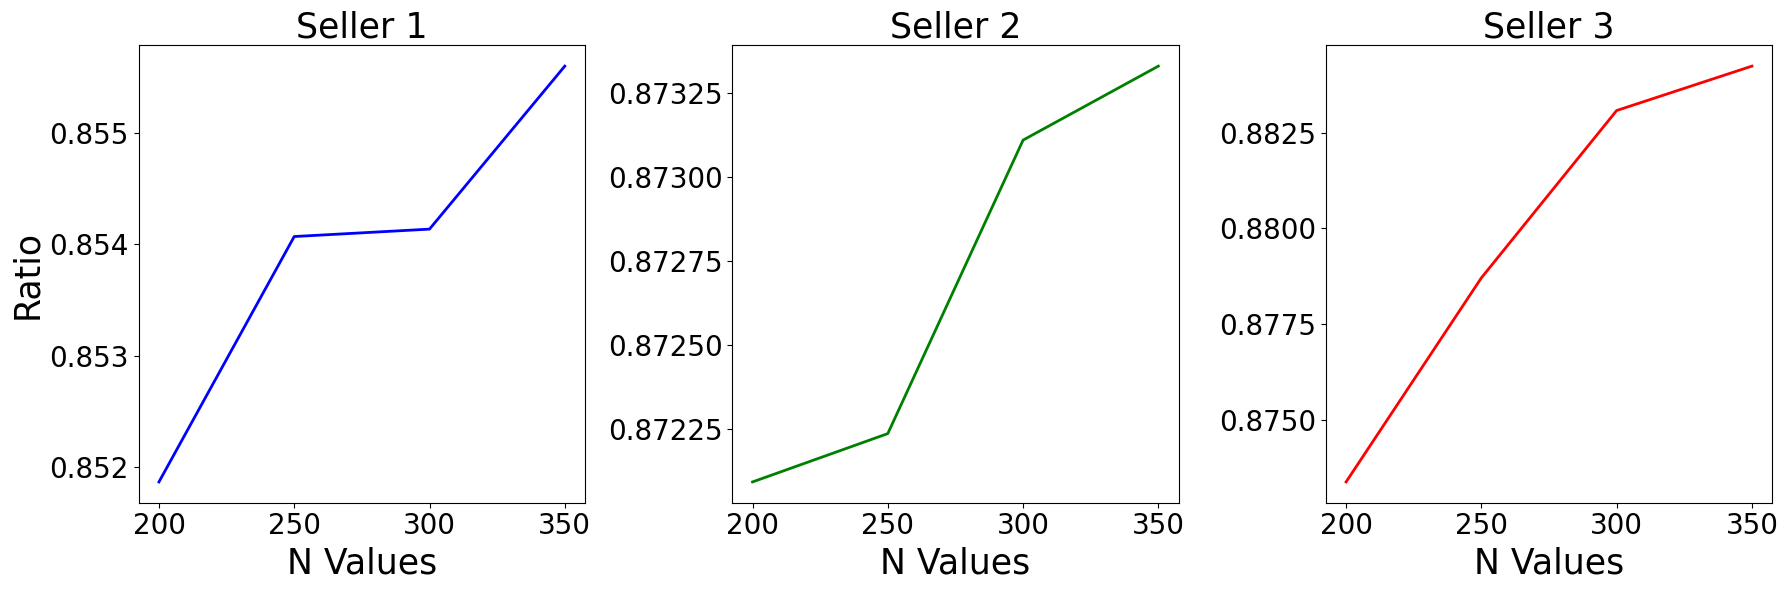

In [28]:
# Adjusting the plotting approach based on the updated requirement to plot 1x3 subplots
N_values = [200,250,300,350]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns of plots

# Plotting for scenario 1 on the first subplot
axes[0].plot(N_values, proportion_s_1, label="2nd Best Price", linewidth=2, color='blue')
axes[0].set_title("Seller 1",fontsize=25)
axes[0].set_xlabel("N Values",fontsize=25)
axes[0].set_ylabel("Ratio",fontsize=25)
axes[0].tick_params(axis='both', labelsize=20)
axes[0].locator_params(axis='y', nbins=6)
axes[0].grid(False)

# Plotting for scenario 2 on the second subplot
axes[1].plot(N_values, proportion_m, label="2nd Best Price", linewidth=2, color='green')
axes[1].set_title("Seller 2",fontsize=25)
axes[1].set_xlabel("N Values",fontsize=25)
axes[1].tick_params(axis='both', labelsize=20)
axes[1].locator_params(axis='y', nbins=6)
#axes[1].set_ylabel("Ratio")
axes[1].grid(False)

# Plotting for scenario 3 on the third subplot
axes[2].plot(N_values, proportion_sa, label="2nd Best Price", linewidth=2, color='red')
axes[2].set_title("Seller 3",fontsize=25)
axes[2].set_xlabel("N Values",fontsize=25)
axes[2].tick_params(axis='both', labelsize=20)
axes[2].locator_params(axis='y', nbins=5)
#axes[2].set_ylabel("Ratio")
axes[2].grid(False)

# Adjusting layout for better spacing
plt.tight_layout()

# Show plot
plt.show()
